

### **WHAT DOES THIS NOTEBOOK CONTAINS:**

## This Notebook is divided into three parts:

#### **PART: 1 Question to Embedding**
#### **PART: 2 Loading and Preparaing the dataset for the Model**
#### **PART: 3 Making the Model**


* This notebook does not contain the exact implementation of the Stacked Attention Network, but has been inspired from that paper and the slides that has been mentioned above, and there are drawbacks (because I was unaware of **attention layer** and it's implementation in TensorFlow 2.0, and hence used some simple **Dense** layers in those places)

* This notebook starts from just loading data, which are mentioned as below:
1. **trainset.json**: 

Contains a list of following enteries: 

              * qid
              * image_name
              * image_organ
              * answer
              * answer_type
              * question
              * question_type
              * phrase_type
An example is: {"qid": 1, "image_name": "synpic54610.jpg", "image_organ": "HEAD", "answer": "Yes", "answer_type": "CLOSED", "question_type": "PRES", "question": "Are regions of the brain infarcted?", "phrase_type": "freeform"}

2. **VQA_RAD Image Folder** : This folder contains the images (in .jpg format), whose name are the qid (as mentioned in the trainset.json)

In [42]:
# # !pip install h5py
# from google.colab import drive
# drive.mount('/content/drive',force_remount=True)

# **PART: 1 Question to Embedding :**

---



---











NOTE: If you are running for the first time, this is an important part to create some important files, but once you have ran it, no need to run in the future sessions

This part of the notebook does the following function:

* Load the **GoogleNews vectors** ([link](https://drive.google.com/file/d/0B7XkCwpI5KDYNlNUTTlSS21pQmM/view?usp=sharing)) (Note if this is your first step, open the link, it will take you to your Google Drive, and then create a copy of the file)

More information about GoogleNews Vectors can be found out [here](https://code.google.com/archive/p/word2vec/)

* Now, having loaded the model, what we need to do is, to create a h5 file, so that dataset can be easily prepared. Each of the h5 file will contain : 1. Question Vector 2. Answer (Label) 

1. Read the question and the answer from **trainset.json**
2. Perform the tokenization on the **questions**, and then convert each of the question into its, corresponding **feature vector** (with the help of **GoogleNews vectors**)
3. Convert the answer into its label (i.e for example yes -> 0, no -> 1, right ->2, etc.)
4. Finally, we have question vector and answer (in label), hence we can store it in a .h5py file format (having the filename as the question id (qid))

In [43]:
import warnings
warnings.filterwarnings('ignore')

In [44]:
import gensim
from gensim.models.keyedvectors import KeyedVectors
model_path = r'./Copy of GoogleNews-vectors-negative300.bin.gz'            # Path where the model is stored
model_w2v = gensim.models.KeyedVectors.load_word2vec_format(model_path, binary=True)            # Loading the model using gensim

In [45]:
import json
import h5py
import numpy as np
import copy
from random import shuffle, seed
import sys
import os.path
import argparse
import glob
import numpy as np
import scipy.io
import pdb
import string
import h5py
import nltk
nltk.download('punkt')
from nltk.tokenize import word_tokenize
import gensim
import json
import re
import cv2
import matplotlib.pyplot as plt



def extract_feat(doc):
  '''
    Input: A sentence
    Output : Word Embedding of the sentence 

    Note : In order to maintain uniformity in the word embedding of the question, I have used padding (which would be shown later) with a maximum length of 21 (since this
    is the longest length of the question in trainset.json)
  '''
  feat = []

  for word in doc:
      try:
          feat.append(model_w2v[word])
      except:
          pass
  return feat

def tokenize(sentence):

    ''' Perform Tokenization '''
    return [i for i in re.split(r"([-.\"',:? !\$#@~()*&\^%;\[\]/\\\+<>\n=])", sentence) if i!='' and i!=' ' and i!='\n']

def prepro_question(imgs, method):
    # preprocess all the question
    print('example processed tokens:')

    '''
    Input: The question from trainset.json
    Performs tokenization and lowering of the question
    Output: Embedded version of the question

    Note that: We have still not padded the questions, just for information each of the word will be a 300 Dimensional Vector,
    hence, the word vector (which will be obtained after padding) will be a (21,300) Dimensional
    '''
    for i,img in enumerate(imgs):
        s = img['question'].lower()
        if method == 'nltk':
            txt = word_tokenize(str(s).lower())
        else:
            txt = tokenize(s)
        img['processed_tokens'] = txt
        if i < 10: print(txt)
        if i % 1000 == 0:
            sys.stdout.write("processing %d/%d (%.2f%% done)   \r" %  (i, len(img), i*100.0/len(imgs)) )
            sys.stdout.flush()   
    return imgs

def get_top_answers(imgs, num_ans):

    """
    Print the questions and returns the time, one answer is repeated
    """
    counts = {}
    for img in imgs:
        try:
            ans = img['answer'].lower()  # If the string is a number, it would result into error
        except :
            ans = str(img['answer'])
        counts[ans] = counts.get(ans, 0) + 1

    cw = sorted([(count,w) for w,count in counts.items()], reverse=True)
    print('top answer and their counts:') 
    print('\n'.join(map(str,cw[:20])))
    
    vocab = []
    for i in range(min(num_ans,len(cw))):
        vocab.append(cw[i][1])

    return vocab[:num_ans]


manualMap = { 'none': '0', 'zero': '0', 'one': '1', 'two': '2', 'three':
                  '3', 'four': '4', 'five': '5', 'six': '6', 'seven': '7',
                  'eight': '8', 'nine': '9', 'ten': '10' }

imgs_train = json.load(open('./trainset.json' , 'r'))      # Unnnecesarily, i have used the same file two times
num_ans = 1000
top_ans = get_top_answers(imgs_train, num_ans)                         
atoi = {w:i for i,w in enumerate(top_ans)}                   # Word : Count
itoa = {i:w for i,w in enumerate(top_ans)}                   # Count : Word
feat_dim = 300                                               # 300 Dimensional Vector
imgs_data_train = json.load(open('./trainset.json' , 'r'))  # trainset.json
num_ans = 10    # Even 1 should work fine, but I had taken reference from COCO dataset, and hence, 10 (10 represents the top 10 answers to a picture)
method = 'nltk'
max_length = 21                       # Max Length of the question
dir_path = "./QA"    # The path where we will be storing .h5 file
N = len(imgs_data_train)

image_path = './VQA_RAD Image Folder'

def save_data():
    
 
        for i,img in enumerate(imgs_data_train):
            #print('X' , img['ques_id'])
            img_path = image_path+img['image_name']  

            s = img['question']
            print(i,s)   # Print the number and the question
            if method == 'nltk':
                try:
                    txt = word_tokenize(str(s).lower())
                except :
                    txt = str(s)
            else:
                    txt = tokenize(s)

            img['processed_tokens'] = txt            
            question_id = img['qid']
            feat = np.array(extract_feat(img['processed_tokens']))
            label_arrays = np.zeros((1, max_length, feat_dim), dtype='float32')
            label_length = min(max_length, len(feat)) # record the length of this sequence
            label_arrays[0, :label_length, :] = feat
            try:
                ans_arrays = atoi[img['answer'].lower()]
            except :
                ans_arrays = atoi[str(img['answer'])]

            f = h5py.File(os.path.join( dir_path , str(question_id) + '.h5'), "w")
            f.create_dataset("ques_train", dtype='float32', data=label_arrays)
            f.create_dataset("answers", dtype='uint32', data=ans_arrays)
            f.close()
        return    
 
data = save_data()

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\pc\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


top answer and their counts:
(884, 'no')
(829, 'yes')
(35, 'right')
(31, 'axial')
(23, 'left')
(15, 'fat')
(14, 'pa')
(12, 'right lung')
(12, 'pancreas')
(12, 'one')
(11, 'left kidney')
(11, 'diffuse')
(10, 'right upper lobe')
(10, 'right sided pleural effusion')
(10, 'right side')
(10, 'ct')
(10, 'brain')
(9, 'lateral ventricles')
(9, 'bilateral')
(8, 'subarachnoid')
0 Are regions of the brain infarcted?
1 Are the lungs normal appearing?
2 Is there evidence of a pneumothorax
3 What type of imaging does this not represent?
4 Is this a MRI of the chest?
5 What is not pictured in this image?
6 Is the trachea midline?
7 Is there evidence of an aortic aneurysm?
8 Where is the abnormality?
9 Is there blunting of the costovertebral angles?
10 Which organ system is abnormal in this image?
11 Where is the pathology in this image?
12 Is there a pneumothorax?
13 What type of imaging is this?
14 What organ system is pictured?
15 Is there a fracture?
16 Is there swelling of the grey matter?
17 Is 

<a id="t1."></a>
# **PART: 2 Loading and Preparaing the dataset for the Model:**

* So, we have saved each of the question vector and answer vector in a .h5 file
* Now according to [slides](http://www.cs.virginia.edu/~vicente/vislang/slides/wasimonica.pdf), we need to convert the image into a 448 * 448 * 3 images, and then pass it through some preprocessing layers to convert into 14 * 14 * 512 (which will be reshaped to 196 * 512, where each region will be 1 * 1* 512)
* For preprocessing the image, we would use the VGG16 preprocessing layer, which would help in coverting the image to 14 * 14 * 512 dimension ( will be applied while building the model)

In [46]:
import json
import h5py
import numpy as np
import copy
from random import shuffle, seed
import sys
import os.path
import argparse
import glob
import numpy as np
import scipy.io
import pdb
import string
import h5py
import nltk
from nltk.tokenize import word_tokenize
import gensim
import json
import re
import cv2
import tensorflow as tf
import numpy as np
import keras
import pandas as pd
import os
import matplotlib.pyplot as plt
dropout_rate = 0.4
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

# -------------------------------------------------------------------------------------------------------------
# The below part is same as that of part 1

def extract_feat(doc):
    feat = []
    for word in doc:
        try:
            feat.append(model_w2v[word])
        except:
            pass
    return feat

def tokenize(sentence):
    return [i for i in re.split(r"([-.\"',:? !\$#@~()*&\^%;\[\]/\\\+<>\n=])", sentence) if i!='' and i!=' ' and i!='\n'];

def prepro_question(imgs, method):
  
    # preprocess all the question
    print('example processed tokens:')
    for i,img in enumerate(imgs):
        s = img['question'].lower()
        if method == 'nltk':
            txt = word_tokenize(str(s).lower())
        else:
            txt = tokenize(s)
        img['processed_tokens'] = txt
        if i < 10: print(txt)
        if i % 1000 == 0:
            sys.stdout.write("processing %d/%d (%.2f%% done)   \r" %  (i, len(img), i*100.0/len(imgs)) )
            sys.stdout.flush()   
    return imgs

def get_top_answers(imgs, num_ans):
    counts = {}
    for img in imgs:
        try:
            ans = img['answer'].lower() 
        except :
            ans = str(img['answer'])
        counts[ans] = counts.get(ans, 0) + 1 # Frequency count

    cw = sorted([(count,w) for w,count in counts.items()], reverse=True)
    # print('top answer and their counts:') 
    # print('\n'.join(map(str,cw[:20])))
    
    vocab = []
    for i in range(min(num_ans,len(cw))):
        vocab.append(cw[i][1])

    return vocab[:num_ans]


def filter_question(imgs, atoi):
    new_imgs = []
    for i, img in enumerate(imgs):
            new_imgs.append(img)

    print('question number reduce from %d to %d '%(len(imgs), len(new_imgs)))
    return new_imgs
# Old Part finishes
# ---------------------------------------------------------------------------------------------------------------------
# New part starts
# -------------------------------------------------------------------------------------------------------------------
def image_layer(input_shape):
    '''
    Input : Shape of the image
    Output : VGG16 Preprocessing model
    '''
    base_model = tf.keras.applications.VGG16(input_shape=input_shape, include_top=False,weights='imagenet')
    base_model.trainable = False # Do not train it
    x = base_model.layers[-2].output  # Shape would be (28*28*512)
    x = tf.reshape(x , [-1,x.shape[2]*x.shape[1] , x.shape[3]]) # Shape would be (1,784,512)
    x = tf.keras.layers.Dense(1024) # This step can be found out in the slides, that after feature extraction, they are connecting a dense layer, slide - 6 (Transform into a same size vector)
    return x

def vgg_preprocessing(model,image):
  ''' Takes a tensor as an input, and returns a pre processed version of the image'''
  return model(image)

def load_data():

  '''
  Input: Nothing

  Output: Returns list containing the following four elements in a tuple
  (preprocessed version of the image,embedded question,embedded answer, question id)
  '''

  images = []
  questions = []
  answers = []
  ids = []
        
  #print(start,end)
  #arrs = np.random.randint(0,len(imgs_data_train),batch)
  #data = [imgs_data_train[i] for i in arrs]
        
  data = imgs_data_train   # trainset.json
  model = image_layer(input_shape = (448,448,3)) # Making VGG16 Model
  for i,img in enumerate(data):
        
      img_path = img['image_name']  # Image Name
      question_id = img['qid']      # Question id

      #label_arrays = np.zeros((1, max_length, feat_dim), dtype='float32') # Somethings are taken directly from 
            
      with h5py.File(os.path.join(dir_path,str(question_id) + '.h5'),'r') as hf:
        question = hf['ques_train'][()] # Embedded question
        answer = hf['answers'][()]      # Embedded answer

      # print(question, answer)
      image = cv2.imread(os.path.join('./VQA_RAD Image Folder',img_path) , cv2.IMREAD_COLOR) # Reading the image
      image = cv2.cvtColor(image , cv2.COLOR_BGR2RGB)
      image = cv2.resize(image , (448,448)) # Reshape

      '''
      Small Note : I had not applied the VGG Preprocessing here, because I wanted to use the original shape of 448, and then, I would 
      attach the VGG Model, while making the model, I think this makes sense :)
      '''
      #image = vgg_preprocessing(model,image)
      # Apply VGG16 Preprocessings

      images.append(image)
      questions.append(np.array(question))
      answers.append(np.array(answer))
      ids.append(question_id)     
      if i%100==0:
        print("Processed =>",i,' which is',round(100*i/len(data),2),'%')          
        
  questions = np.reshape(np.array(questions) , [-1,max_length,feat_dim])
  return (np.array(images) , questions ,np.array(answers) , np.array(ids))

imgs_train = json.load(open('./trainset.json' , 'r'))
num_ans = 1000
top_ans = get_top_answers(imgs_train, num_ans )
atoi = {w:i for i,w in enumerate(top_ans)}
itoa = {i:w for i,w in enumerate(top_ans)}
feat_dim = 300
imgs_data_train = json.load(open('./trainset.json' , 'r'))
num_ans = 10
method = 'nltk'
max_length = 21
dir_path = "./QA"
N = len(imgs_data_train)

# ---------------------------------------------------------------------------------------
# New part finishes

In [47]:
import tensorflow as tf
import numpy as np
import keras,h5py
import pandas as pd
import os
import json
from tqdm import tqdm 
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')
from keras.applications.vgg16 import VGG16
import keras.activations
import keras.backend as kbe
from keras.callbacks import EarlyStopping
import tensorflow.keras.layers as layers
from keras.layers import Activation, Add, Concatenate, Conv1D, Dense, Dropout, Embedding, Softmax
from keras.layers import Input, GlobalMaxPooling1D, Lambda, Multiply, RepeatVector, Reshape
from keras.layers import BatchNormalization 
from keras.models import Model
from keras.regularizers import l2
import pickle
from pprint import pprint

''' These parameters are for some of the previous attempts, so ignore it, the main part is : datagen = load_data(), and I don't want to remove all of these,
because indeed there can be some ideas coming out from these lines of code'''

embed_size = 300
q_len = 21
height = 224
width = 224
lstm_units = 256
attention_dim = 512
num_output = 1000
max_questions = 3064

batch_size = 32
lr = 0.001
articles = ['a', 'an', 'the']
manualMap = { 'none': '0', 'zero': '0', 'one': '1', 'two': '2', 'three':
                  '3', 'four': '4', 'five': '5', 'six': '6', 'seven': '7',
                  'eight': '8', 'nine': '9', 'ten': '10' }


datagen = load_data()   # Load the Data

Processed => 0  which is 0.0 %
Processed => 100  which is 3.26 %
Processed => 200  which is 6.53 %
Processed => 300  which is 9.79 %
Processed => 400  which is 13.05 %
Processed => 500  which is 16.32 %
Processed => 600  which is 19.58 %
Processed => 700  which is 22.85 %
Processed => 800  which is 26.11 %
Processed => 900  which is 29.37 %
Processed => 1000  which is 32.64 %
Processed => 1100  which is 35.9 %
Processed => 1200  which is 39.16 %
Processed => 1300  which is 42.43 %
Processed => 1400  which is 45.69 %
Processed => 1500  which is 48.96 %
Processed => 1600  which is 52.22 %
Processed => 1700  which is 55.48 %
Processed => 1800  which is 58.75 %
Processed => 1900  which is 62.01 %
Processed => 2000  which is 65.27 %
Processed => 2100  which is 68.54 %
Processed => 2200  which is 71.8 %
Processed => 2300  which is 75.07 %
Processed => 2400  which is 78.33 %
Processed => 2500  which is 81.59 %
Processed => 2600  which is 84.86 %
Processed => 2700  which is 88.12 %
Processed =

### Creating the Dataset: We do this, by renaming the contents of .h5 file

In [48]:
from tqdm import tqdm

In [49]:
images,questions,answers,ids =datagen[0],datagen[1],datagen[2],datagen[3]
print("Images have a size of:",images.shape)
print("Questions have a size of:",questions.shape)
print("Answers have a size of:",answers.shape)
print("Ids have a size of:",ids.shape)
dir_path = r"./QA" # The directory where the .h5 file for each entry is saved
print(dir_path)
m = 100
for i in tqdm(range(images.shape[0])):

    filename = os.path.join( dir_path , str(ids[i])) + '.h5'

    with h5py.File(filename,'r+') as f:
      f.create_dataset("quest1_train", dtype='float32', data=questions[i]) # Question Embedding
      f.create_dataset("imaget1_vector", dtype='float32', data=images[i]) # Image Embedding (Not preprocessed)
      f.create_dataset("answerst1", dtype='uint32', data=answers[i])      # Answers in embedded form
      # Check if file is already open

    if i%m ==0:
        print("Processed =>", i,' total percentage =>', round(100*i/images.shape[0],2),' %')
print("Your processing has been done")

Images have a size of: (3064, 448, 448, 3)
Questions have a size of: (3064, 21, 300)
Answers have a size of: (3064,)
Ids have a size of: (3064,)
./QA


  1%|          | 36/3064 [00:00<00:09, 333.60it/s]

Processed => 0  total percentage => 0.0  %


  2%|▏         | 74/3064 [00:00<00:08, 352.62it/s]

Processed => 100  total percentage => 3.26  %


  8%|▊         | 249/3064 [00:01<00:13, 208.33it/s]

Processed => 200  total percentage => 6.53  %


 11%|█▏        | 346/3064 [00:01<00:10, 264.04it/s]

Processed => 300  total percentage => 9.79  %


 14%|█▍        | 441/3064 [00:02<00:08, 292.46it/s]

Processed => 400  total percentage => 13.05  %


 18%|█▊        | 538/3064 [00:02<00:08, 310.90it/s]

Processed => 500  total percentage => 16.32  %


 21%|██        | 638/3064 [00:02<00:07, 321.27it/s]

Processed => 600  total percentage => 19.58  %


 24%|██▍       | 735/3064 [00:03<00:08, 271.65it/s]

Processed => 700  total percentage => 22.85  %


 27%|██▋       | 815/3064 [00:03<00:09, 227.95it/s]

Processed => 800  total percentage => 26.11  %


 30%|███       | 927/3064 [00:04<00:10, 211.05it/s]

Processed => 900  total percentage => 29.37  %


 34%|███▍      | 1035/3064 [00:04<00:09, 204.44it/s]

Processed => 1000  total percentage => 32.64  %


 37%|███▋      | 1124/3064 [00:05<00:10, 193.73it/s]

Processed => 1100  total percentage => 35.9  %


 40%|████      | 1233/3064 [00:05<00:08, 207.50it/s]

Processed => 1200  total percentage => 39.16  %


 44%|████▍     | 1341/3064 [00:06<00:08, 203.77it/s]

Processed => 1300  total percentage => 42.43  %


 47%|████▋     | 1429/3064 [00:06<00:07, 213.12it/s]

Processed => 1400  total percentage => 45.69  %


 50%|████▉     | 1520/3064 [00:06<00:07, 199.35it/s]

Processed => 1500  total percentage => 48.96  %


 53%|█████▎    | 1634/3064 [00:07<00:06, 213.54it/s]

Processed => 1600  total percentage => 52.22  %


 56%|█████▌    | 1720/3064 [00:07<00:06, 197.60it/s]

Processed => 1700  total percentage => 55.48  %


 60%|█████▉    | 1824/3064 [00:08<00:09, 134.11it/s]

Processed => 1800  total percentage => 58.75  %


 63%|██████▎   | 1920/3064 [00:09<00:09, 121.77it/s]

Processed => 1900  total percentage => 62.01  %


 66%|██████▌   | 2025/3064 [00:10<00:07, 135.30it/s]

Processed => 2000  total percentage => 65.27  %


 69%|██████▉   | 2124/3064 [00:10<00:06, 143.82it/s]

Processed => 2100  total percentage => 68.54  %


 72%|███████▏  | 2219/3064 [00:11<00:05, 141.93it/s]

Processed => 2200  total percentage => 71.8  %


 76%|███████▌  | 2322/3064 [00:12<00:05, 126.93it/s]

Processed => 2300  total percentage => 75.07  %


 79%|███████▉  | 2415/3064 [00:13<00:05, 123.61it/s]

Processed => 2400  total percentage => 78.33  %


 82%|████████▏ | 2514/3064 [00:14<00:05, 107.67it/s]

Processed => 2500  total percentage => 81.59  %


 85%|████████▌ | 2614/3064 [00:14<00:03, 114.01it/s]

Processed => 2600  total percentage => 84.86  %


 89%|████████▊ | 2716/3064 [00:15<00:02, 138.78it/s]

Processed => 2700  total percentage => 88.12  %


 92%|█████████▏| 2826/3064 [00:16<00:01, 136.74it/s]

Processed => 2800  total percentage => 91.38  %


 95%|█████████▌| 2922/3064 [00:17<00:01, 137.29it/s]

Processed => 2900  total percentage => 94.65  %


 98%|█████████▊| 3013/3064 [00:17<00:00, 143.42it/s]

Processed => 3000  total percentage => 97.91  %


100%|██████████| 3064/3064 [00:18<00:00, 168.86it/s]

Your processing has been done


<a id="t2."></a>
# **PART: 3 Making the Model**  ( START RUNNING FROM THIS CELL, IF YOU HAVE ALREADY RAN IT ONCE, AND IS RUNING AGAIN)
So, we go by the following rule:

1. Pre-process the image (making it (None,196,512)), where 196 represents 196 regions, wach of 32 * 32 pixel
2. Make it of the same size of that of question embedding 
3. Now, we will pass the ques layer through LSTM, and pass preprocessed image through dense network (activation is tanh).
4. Then, we will concatenate both the vectors, and then, pass through dense layers, and final layer with softmax function
5. The loss function is Sparse Categorical Cross Entropy, optimizer is Adam with learning rate of 0.01, and batch size of 32, and for 50 epochs

In [50]:
# link - http://www.cs.virginia.edu/~vicente/vislang/slides/wasimonica.pdf
import os,h5py
# Image Model
import tensorflow as tf
import numpy as np
from tqdm import tqdm
from tensorflow.keras import Model
import warnings
warnings.filterwarnings('ignore')

'''  Preprocessing with the VGG 16 Model  '''

model = tf.keras.applications.VGG16(include_top=False,weights='imagenet',
        input_shape=(448,448,3))
#print("The Last layer")
last_layer = model.layers[-1].output   # Last layer has an output layer of (14,14,512)
model = Model(model.input,last_layer)
model.trainable = False
# print(model.summary())
def extract_feature(image):
    ''' Preprocessing with VGG Netowrk'''
    image = model(image)
    return image  # Shape is (196,512)

'''  The below model will convert (196,512) to (21,300) (i.e same as the dimension of word embedding)  '''

dimen_red = tf.keras.Sequential()  # Use for converting (196,512) -> (21,300)
dimen_red.add(tf.keras.layers.Conv2D(300,kernel_size=(1,1),input_shape= (14,14,512)))
dimen_red.add(tf.keras.layers.Reshape((196,300)))
dimen_red.add(tf.keras.layers.Permute((2,1)))  # Reshaping about the axis, useful for applying the dense network
dimen_red.add(tf.keras.layers.Dense(21))
dimen_red.add(tf.keras.layers.Permute((2,1)))  # Reshaping about the axis, useful for applying the dense network

train_dir = r"./QA/" # Containing .h5 file
images = []
answers = []
questions = []
count = 0
content = os.listdir(train_dir)[:3000]   # The GPU Memory became full after this, hence had to take just these much samples :(
length = len(content)
batch_size = 8
num_batches = int(np.ceil(len(content) / batch_size))

for batch_idx in tqdm(range(num_batches)):
    batch_start = batch_idx * batch_size
    batch_end = min(batch_start + batch_size, len(content))
    batch_files = content[batch_start:batch_end]

    # Loop over the HDF5 files in the current batch and read the data
    for i in batch_files:
        file = h5py.File(train_dir + i, 'r')
        images.append(np.array(file['imaget1_vector'][()]))
        answers.append(np.array(file['answerst1'][()]))
        questions.append(np.array(file['quest1_train'][()]))

        file.close()

        # Print progress every 100 files
        if len(images) % 100 == 0:
            print(f"Processed {len(images)} files")

# Convert the data to TensorFlow tensors
images = tf.convert_to_tensor(np.array(images))
answers = tf.convert_to_tensor(np.array(answers))
questions = tf.convert_to_tensor(np.array(questions))



  4%|▎         | 14/375 [00:01<00:29, 12.25it/s]

Processed 100 files


  7%|▋         | 26/375 [00:02<00:29, 11.94it/s]

Processed 200 files


 11%|█         | 40/375 [00:02<00:16, 19.94it/s]

Processed 300 files


 14%|█▍        | 52/375 [00:03<00:16, 20.09it/s]

Processed 400 files


 17%|█▋        | 64/375 [00:03<00:14, 21.31it/s]

Processed 500 files


 21%|██        | 78/375 [00:04<00:16, 17.74it/s]

Processed 600 files


 24%|██▍       | 90/375 [00:05<00:16, 17.53it/s]

Processed 700 files


 27%|██▋       | 102/375 [00:06<00:15, 17.65it/s]

Processed 800 files


 31%|███       | 117/375 [00:06<00:10, 23.68it/s]

Processed 900 files


 34%|███▍      | 129/375 [00:07<00:10, 24.07it/s]

Processed 1000 files


 38%|███▊      | 141/375 [00:07<00:10, 22.52it/s]

Processed 1100 files


 41%|████      | 153/375 [00:08<00:09, 22.22it/s]

Processed 1200 files


 43%|████▎     | 162/375 [00:08<00:09, 22.87it/s]

Processed 1300 files


 47%|████▋     | 177/375 [00:09<00:09, 21.94it/s]

Processed 1400 files


 51%|█████     | 192/375 [00:10<00:08, 21.71it/s]

Processed 1500 files


 54%|█████▍    | 202/375 [00:11<00:12, 13.33it/s]

Processed 1600 files


 57%|█████▋    | 214/375 [00:12<00:13, 12.38it/s]

Processed 1700 files


 61%|██████    | 227/375 [00:12<00:09, 16.04it/s]

Processed 1800 files


 64%|██████▍   | 241/375 [00:13<00:06, 21.18it/s]

Processed 1900 files


 67%|██████▋   | 253/375 [00:14<00:05, 22.03it/s]

Processed 2000 files


 71%|███████   | 265/375 [00:14<00:04, 22.52it/s]

Processed 2100 files


 74%|███████▍  | 277/375 [00:15<00:04, 22.47it/s]

Processed 2200 files


 77%|███████▋  | 289/375 [00:15<00:04, 19.69it/s]

Processed 2300 files


 81%|████████  | 302/375 [00:16<00:03, 23.32it/s]

Processed 2400 files


 84%|████████▎ | 314/375 [00:17<00:03, 17.21it/s]

Processed 2500 files


 87%|████████▋ | 328/375 [00:17<00:02, 17.08it/s]

Processed 2600 files


 91%|█████████ | 340/375 [00:18<00:02, 16.44it/s]

Processed 2700 files


 93%|█████████▎| 350/375 [00:19<00:02, 11.69it/s]

Processed 2800 files


 97%|█████████▋| 364/375 [00:20<00:01,  9.92it/s]

Processed 2900 files


100%|██████████| 375/375 [00:21<00:00, 17.11it/s]


Processed 3000 files


In [51]:
# pd.DataFrame(np.array(images)).to_csv('Images')
# pd.DataFrame(np.array(questions)).to_csv('Questions')
# pd.DataFrame(np.array(answers)).to_csv('Answers')

In [52]:
# l = []
# length = np.array(images).shape[0]
# for i,img in enumerate(images):
#   l.append(model(img.reshape(1,448,448,3)))  # It was not possible directly on GPU, hence had to use for loop
#   if i%100 ==0:
#     print("The count is:",i,"and the percentage proportion is:",round(100*i/length,2),'%')
# images = tf.convert_to_tensor(np.array(l) )
import tensorflow as tf
import numpy as np

l = []
length = np.array(images).shape[0]
for i, img in enumerate(images):
    img = tf.reshape(img, (1, 448, 448, 3))
    l.append(model(img))  # Assuming `model` is a TensorFlow model

    if i % 100 == 0:
        print("The count is:", i, "and the percentage proportion is:", round(100 * i / length, 2), '%')

images = tf.convert_to_tensor(np.array(l))



The count is: 0 and the percentage proportion is: 0.0 %
The count is: 100 and the percentage proportion is: 3.33 %
The count is: 200 and the percentage proportion is: 6.67 %
The count is: 300 and the percentage proportion is: 10.0 %
The count is: 400 and the percentage proportion is: 13.33 %
The count is: 500 and the percentage proportion is: 16.67 %
The count is: 600 and the percentage proportion is: 20.0 %
The count is: 700 and the percentage proportion is: 23.33 %
The count is: 800 and the percentage proportion is: 26.67 %
The count is: 900 and the percentage proportion is: 30.0 %
The count is: 1000 and the percentage proportion is: 33.33 %
The count is: 1100 and the percentage proportion is: 36.67 %
The count is: 1200 and the percentage proportion is: 40.0 %
The count is: 1300 and the percentage proportion is: 43.33 %
The count is: 1400 and the percentage proportion is: 46.67 %
The count is: 1500 and the percentage proportion is: 50.0 %
The count is: 1600 and the percentage proport

In [53]:
l = []
length = images.shape[0]
for i,j in enumerate(images):
  l.append(dimen_red(j))     # Making it to the same shape as that of question embedding
  if i%100 ==0:
    print("The count is:",i,"and the percentage proportion is:",round(100*i/length,2),'%')
images = tf.convert_to_tensor(np.array(l))

The count is: 0 and the percentage proportion is: 0.0 %
The count is: 100 and the percentage proportion is: 3.33 %
The count is: 200 and the percentage proportion is: 6.67 %
The count is: 300 and the percentage proportion is: 10.0 %
The count is: 400 and the percentage proportion is: 13.33 %
The count is: 500 and the percentage proportion is: 16.67 %
The count is: 600 and the percentage proportion is: 20.0 %
The count is: 700 and the percentage proportion is: 23.33 %
The count is: 800 and the percentage proportion is: 26.67 %
The count is: 900 and the percentage proportion is: 30.0 %
The count is: 1000 and the percentage proportion is: 33.33 %
The count is: 1100 and the percentage proportion is: 36.67 %
The count is: 1200 and the percentage proportion is: 40.0 %
The count is: 1300 and the percentage proportion is: 43.33 %
The count is: 1400 and the percentage proportion is: 46.67 %
The count is: 1500 and the percentage proportion is: 50.0 %
The count is: 1600 and the percentage proport

In [54]:
images = tf.reshape(images,[length,21,300])
img = images  #Tensor containing images
que = questions  # Tensor containing question vector
img = img/255.0 # Normalizing

In [55]:
np.array(que).shape,np.array(img).shape

((3000, 21, 300), (3000, 21, 300))

In [56]:
''' The below mentioned two Input objects of keras will be useful for making the model '''

ques = tf.keras.layers.Input((21,300))  # Input Model (for ques)
images = tf.keras.layers.Input((21,300)) # Input Model (for images)

## Note: I had not applied Attention Network as mentioned in the [paper](https://arxiv.org/pdf/1511.02274.pdf), and had seen some implementation of SAN, where they used Dense network with tanh activation, and hence we would do the same

In [57]:
from keras.utils import to_categorical
from keras.models import Sequential
from keras.layers import Dense, Dropout, Embedding, LSTM, GlobalMaxPooling1D, SpatialDropout1D,Flatten,Concatenate,MultiHeadAttention

''' Imagica is for the preprocessing of the image part'''
imagica = Dense(512,activation='tanh')(images)
imagica = Dense(512,activation='tanh')(images)


''' quesa is for the ques layer, which means preprocessing of the question layer'''
quesa = LSTM(512, dropout = 0.3,return_sequences = True,input_shape = (21,300))(ques)
quesa = Dense(512, activation = 'relu')(quesa)
quesa = Dropout(0.3)(quesa)
quesa = Dense(512, activation = 'relu')(quesa)
quesa = Dropout(0.3)(quesa)

''' Concatenating both image and the question layer'''
# quesa = Concatenate()([quesa,imagica])
# quesa = Flatten()(quesa)
num_attention_heads = 4
key_dim = 32


quesa = Concatenate()([quesa, imagica])

In [58]:
from keras.layers import Dense, Dropout, Embedding, LSTM, GlobalMaxPooling1D, SpatialDropout1D,Flatten,Concatenate,Attention
quesa = tf.expand_dims(quesa, axis=1)

quesa = Attention()([quesa, quesa])
quesa = Flatten()(quesa)
out = tf.keras.layers.Dense(476,activation='softmax')(quesa) # Final output has 476 different categories, you can check by finding length of uniquue answers :)

## Plotting the Model

In [59]:
from keras.utils.vis_utils import plot_model
model = Model([ques,images],[out])
plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model to work.


## Compiling and fitting the model

In [118]:
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate = 0.01),loss ='categorical_crossentropy',metrics=['accuracy'])
# from tensorflow.keras import metrics

# model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate = 0.01),loss ='categorical_crossentropy',metrics=[metrics.mean_absolute_error])

In [119]:
answers.shape

(3000, 476)

In [120]:
answers = tf.keras.utils.to_categorical(answers)

In [121]:
answers.shape

(3000, 476, 2)

In [64]:
model.summary()

Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_7 (InputLayer)           [(None, 21, 300)]    0           []                               
                                                                                                  
 lstm_1 (LSTM)                  (None, 21, 512)      1665024     ['input_7[0][0]']                
                                                                                                  
 dense_11 (Dense)               (None, 21, 512)      262656      ['lstm_1[0][0]']                 
                                                                                                  
 dropout_2 (Dropout)            (None, 21, 512)      0           ['dense_11[0][0]']               
                                                                                            

In [65]:
np.array(answers).shape,np.array(img).shape,np.array(que).shape

((3000, 476), (3000, 21, 300), (3000, 21, 300))

In [66]:
answers.shape,np.array(img).shape,np.array(que).shape

((3000, 476), (3000, 21, 300), (3000, 21, 300))

In [122]:
answers.shape,np.array(img).shape,np.array(que).shape
# history = model.fit([np.array(img),np.array(que)],np.array(answers),epochs = 50,batch_size=32,verbose=1)

((3000, 476, 2), (3000, 21, 300), (3000, 21, 300))

## Saving the Model and analysing the prediction

In [68]:
history = model.fit([np.array(img),np.array(que)],np.array(answers),epochs = 50,batch_size=32,verbose=1)

Epoch 1/50
94/94 [==============================] - 32s 281ms/step - loss: 5.3417 - accuracy: 0.3403
Epoch 2/50
94/94 [==============================] - 26s 276ms/step - loss: 3.4724 - accuracy: 0.5183
Epoch 3/50
94/94 [==============================] - 26s 277ms/step - loss: 4.9561 - accuracy: 0.5743
Epoch 4/50
94/94 [==============================] - 26s 276ms/step - loss: 5.0517 - accuracy: 0.6080
Epoch 5/50
94/94 [==============================] - 26s 276ms/step - loss: 5.5389 - accuracy: 0.6430
Epoch 6/50
94/94 [==============================] - 26s 274ms/step - loss: 5.3845 - accuracy: 0.6747
Epoch 7/50
94/94 [==============================] - 26s 276ms/step - loss: 5.5027 - accuracy: 0.6833
Epoch 8/50
94/94 [==============================] - 26s 272ms/step - loss: 5.2849 - accuracy: 0.7200
Epoch 9/50
94/94 [==============================] - 26s 273ms/step - loss: 5.1836 - accuracy: 0.7363
Epoch 10/50
94/94 [==============================] - 26s 272ms/step - loss: 5.2077 - accura

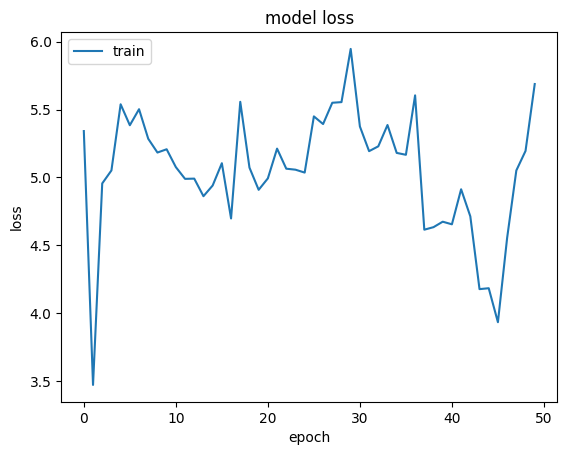

In [69]:
plt.plot(history.history['loss'])
# plt.plot(history.history['accuracy'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train'], loc='upper left')

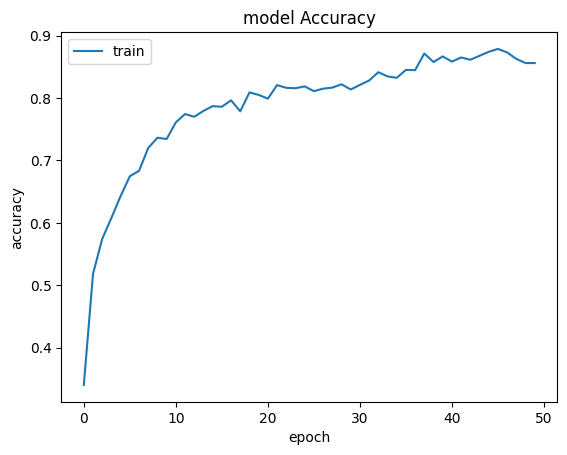

In [96]:
plt.plot(history.history['accuracy'])
# plt.plot(history.history['accuracy'])
plt.title('model Accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train'], loc='upper left')

In [71]:
model.save('VQA_Model')

INFO:tensorflow:Assets written to: VQA_Model\assets


INFO:tensorflow:Assets written to: VQA_Model\assets


Validation Test for validating the model

In [148]:
# Training Error
import pickle
x = open('./cache/trainval_label2ans.pkl','rb')
a2lab = pickle.load(x)
print(np.array(a2lab).shape)
import cv2
img_path = './VQA_RAD Image Folder/'
import matplotlib.pyplot as plt
%matplotlib inline
true = 0
total = 0
for i in range(len(a2lab)):
  try:
    if str(train[i]['answer']).lower() == str(a2lab[prediction[i]]).lower():
      true+=1
      total+=1
    else:
      total+=1
  except:
    print()

(468,)




















In [163]:
print("Validation accuracy "+str(np.round(((true)/total)*100)) + "%")

Validation accuracy 52.0%


In [74]:
prediction = tf.argmax(model.predict([img,(que)]),axis=1).numpy()

94/94 [==============================] - 7s 70ms/step


In [75]:
prediction.shape

(3000,)

(468,)
synpic47196.jpg
The Question is: What is the dark structure underneath the skin?
The answer is: Actual: fat predicted value: no
**************************************************


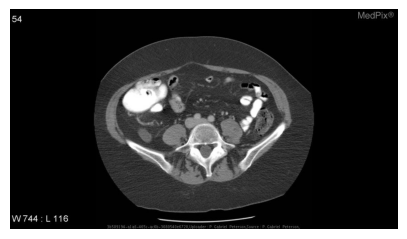

synpic38630.jpg
The Question is: Does this mass likely represent a neoplastic process?
The answer is: Actual: No predicted value: no
**************************************************


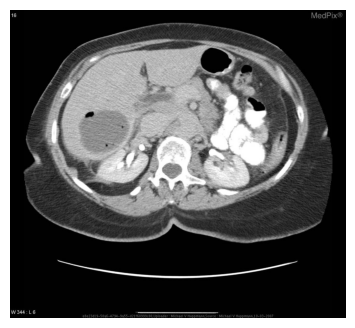

synpic38630.jpg
The Question is: IS this a neoplastic process?
The answer is: Actual: No predicted value: no
**************************************************


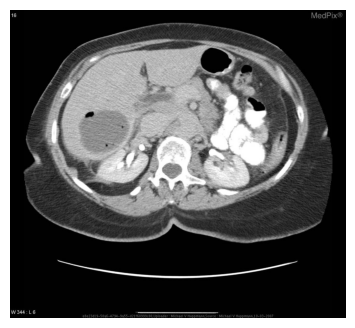

synpic32136.jpg
The Question is: Is the vertebrae fractured?
The answer is: Actual: no predicted value: no
**************************************************


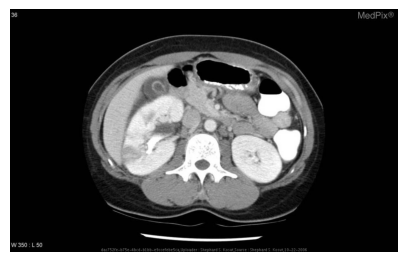

synpic32136.jpg
The Question is: Is there a verterbral fracture?
The answer is: Actual: no predicted value: no
**************************************************


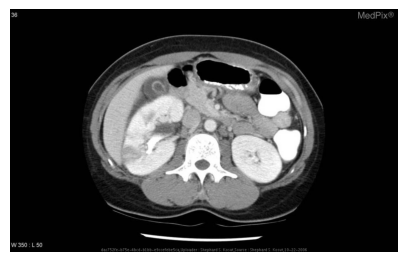

In [154]:
import pickle
x = open('./cache/trainval_label2ans.pkl','rb')
a2lab = pickle.load(x)
print(np.array(a2lab).shape)
import cv2
img_path = './VQA_RAD Image Folder/'
import matplotlib.pyplot as plt
%matplotlib inline
for i in range(135,140):
  plt.figure(figsize=(5,4))
  print(train[i]['image_name'])
  image = cv2.imread(img_path+ train[i]['image_name'])
  plt.imshow(image)
  value = "Actual: "+str(train[i]['answer'])+' predicted value: '+ str(a2lab[prediction[i]])
  plt.axis('off')
  print("The Question is:",train[i]['question'])
  print("The answer is:",value)
  print("*"*50)
  plt.show()

## END OF THE NOTEBOOK :)